In [76]:
import numpy as np
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import pandas as pd
import datetime
import operator
import math
import random
plt.style.use('ggplot')

In [77]:
#Load Dataset
Home_data = pd.read_csv('HomeC.csv', low_memory=False)
nan_removed = pd.DataFrame.dropna(pd.DataFrame(Home_data))
nan_removed.value_counts()

time        use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  Kitchen 38 [kW]  Barn [kW]  Well [kW]  Microwave [kW]  Living room [kW]  Solar [kW]  temperature  icon         humidity  visibility  summary     apparentTemperature  pressure  windSpeed  cloudCover  windBearing  precipIntensity  dewPoint  precipProbability
1451624400  0.932833  0.003483  0.932833            0.000033         0.020700        0.061917        0.442633          0.124150     0.006983          0.013083          0.000417         0.000150         0.000000         0.031350   0.001017   0.004067        0.001517          0.003483    36.14        clear-night  0.62      10.00       Clear       29.26                1016.91   9.18       cloudCover  282.0        0.0000           24.40     0.00                 1
1451960350  0.498450  0.054750  0.498450            0.000000         0.020100

In [78]:
duplicate_removed = (nan_removed[['summary', 'temperature', 'apparentTemperature']].drop_duplicates()).round()
duplicate_removed['summary'].value_counts()

Clear                       5444
Partly Cloudy               1040
Light Rain                   463
Drizzle                      179
Overcast                     104
Rain                          90
Mostly Cloudy                 79
Light Snow                    75
Flurries                      31
Breezy                        27
Snow                          20
Breezy and Partly Cloudy      18
Foggy                         17
Rain and Breezy                3
Heavy Snow                     3
Flurries and Breezy            2
Breezy and Mostly Cloudy       1
Dry                            1
Name: summary, dtype: int64

In [86]:
# df = pd.DataFrame(duplicate_removed)
df_selected = duplicate_removed[duplicate_removed['summary'].str.contains('Snow', case = False, regex = True).fillna(False) | duplicate_removed['summary'].str.contains('Flurries', case = False, regex = True).fillna(False) | duplicate_removed['summary'].str.contains('Overcast', case = False).fillna(False)] 
X = (df_selected[['temperature', 'apparentTemperature']]).values
y = df_selected['summary'].values
data = X
df_selected.value_counts()

summary     temperature  apparentTemperature
Overcast    61.0         61.0                   4
Light Snow  29.0         29.0                   4
Overcast    53.0         53.0                   4
            51.0         51.0                   4
Light Snow  29.0         24.0                   3
                                               ..
            24.0         17.0                   1
            25.0         20.0                   1
                         25.0                   1
            26.0         20.0                   1
Snow        32.0         32.0                   1
Length: 175, dtype: int64

In [80]:
# Definisi Kelas Hierarchical Clustering Manual
class HC:
    def __init__(self, verbose=False, linkage_type='complete'):
        self.verbose= verbose
        self.linkage_type = linkage_type

    def argmin(self, D):
        """
        Given a 2D array, returns the minimum value that is not in the main diagonal, i.e x==y
        and (x,y) index of that value.
        """
        minx, miny = (0,0)
        min_val = 10e5
        for i in range(D.shape[0]):
            for j in range(D.shape[0]):
                if j==i:
                    continue
                else:
                    if D[i,j] < min_val:
                        min_val = D[i,j]
                        minx = i
                        miny = j

        return min_val, minx, miny

    def cluster_distance(self, cluster_members):
        """
        Calculates the cluster euclidean distances.

        Params
        ------
        cluster_members: dict.
            stores the cluster members in format: {key: [item1, item2 ..]}.
            if key is less than X.shape[0] then, it only has itself in the cluster.

        Returns
        -------
        Distance: 2D array.
            Contains distances between each cluster.
        """
        nClusters = len(cluster_members)
        keys = list(cluster_members.keys())
        Distance = np.zeros((nClusters, nClusters))
        for i in range(nClusters):
            ith_elems = cluster_members[keys[i]]
            for j in range(nClusters):
                jth_elems = cluster_members[keys[j]]
                d_in_clusters = euclidean_distances(X[ith_elems], X[jth_elems])
                if self.linkage_type == 'complete':
                    dij = np.max(d_in_clusters)
                elif self.linkage_type == 'single':
                    dij = np.min(d_in_clusters)
                Distance[i,j] = dij

        # so Distance has minimum distance between clusters
        # row and col of Distance denotes element in `keys`
        return Distance

    def fit(self, X):
        """
        Generates the dendrogram.

        Params
        ------
        X: Dataset, shape (nSamples, nFeatures)

        Returns
        -------
        Z: 2D array. shape (nSamples-1, 4).
            Linkage matrix. Stores the merge information at each iteration.
        """
        self.nSamples = X.shape[0]

        cluster_members = dict([(i,[i]) for i in range(self.nSamples)])
        Z = np.zeros((self.nSamples-1,4)) # c1, c2, d, count

        for i in range(0, self.nSamples-1):
            if self.verbose:
                print(f'\n-------\nDebug Line at, i={i}\n--------')

            nClusters = len(cluster_members)
            keys = list(cluster_members.keys())
            # caculate the distance between existing clusters
            D = self.cluster_distance(cluster_members)
            _, tmpx, tmpy = self.argmin(D)
#             tmpx, tmpy = np.unravel_index(np.argmin(D), shape=D.shape)
            if self.verbose:
                print(f'Z:\n{Z}, \nCluster Members: {cluster_members}, D: \n {D}')

            x = keys[tmpx]
            y = keys[tmpy]
            # update Z
            Z[i,0] = x
            Z[i,1] = y
            Z[i,2] = D[tmpx, tmpy] # that's where the min value is
            Z[i,3] = len(cluster_members[x]) + len(cluster_members[y])

            # new cluster created
            cluster_members[i+self.nSamples] = cluster_members[x] + cluster_members[y]
            # remove merged from clusters pool, else they'll be recalculated
            del cluster_members[x]
            del cluster_members[y]

        self.Z = Z
        return self.Z

    def predict(self, n_cluster=3):
        """
        Get cluster label for specific cluster size.

        Params
        ------
        n_cluster: int.
            Number of clusters to keep. Can not be > nSamples

        Returns
        -------
        labels: list.
            Cluster labels for each sample.
        """
        labels = np.zeros((self.nSamples))
        cluster_members = dict([(i,[i]) for i in range(self.nSamples)])
        for i in range(self.nSamples - n_cluster):
            x,y = (Z[i,0], Z[i,1])
            cluster_members[self.nSamples + i] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]

        keys = list(cluster_members.keys())

        for i in range(len(keys)):
            samples_in_cluster = cluster_members[keys[i]]
            labels[samples_in_cluster] = i

        return labels

In [81]:
# Latih Model Hierarchical Clustering Manual
start_time = time.time()
hc = HC(linkage_type = 'complete')
Z = hc.fit(X)
myLabel=hc.predict(n_cluster=3)
end_time=time.time()
manual_execution_time = end_time - start_time
print(f"Manual Hierarchical Clustering Execution Time: {manual_execution_time} seconds")

Manual Hierarchical Clustering Execution Time: 256.6139454841614 seconds


In [82]:
# Latih Model Hierarchical Clustering dari Library Sklearn
start_time = time.time()
clustering = AgglomerativeClustering(n_clusters = 3, linkage = 'complete').fit(X)
skLabel = clustering.labels_
end_time=time.time()
sklearn_execution_time = end_time- start_time
print(f"Sklearn Hierarchical Clustering Execution Time: {sklearn_execution_time} seconds")

Sklearn Hierarchical Clustering Execution Time: 0.001004934310913086 seconds


Cluster Manual
Cluster 1: ['Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast']
Cluster 2: ['Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast', 'Overcast']
Cluster 3: ['Overcast', 'Overcast', '

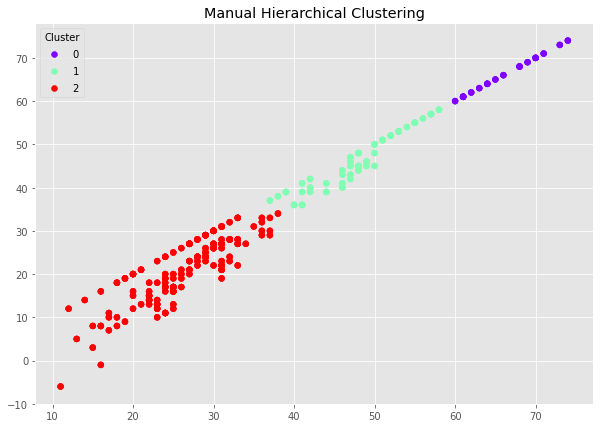

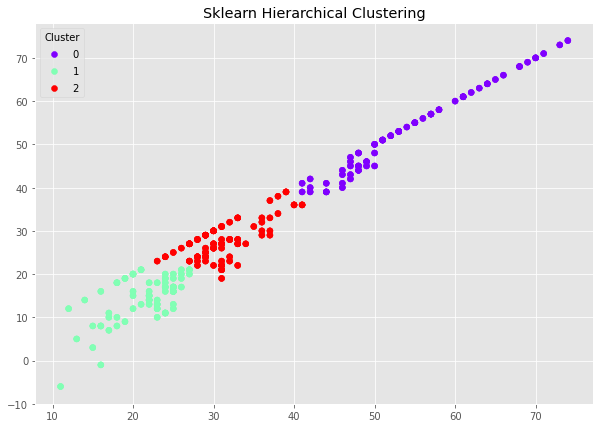

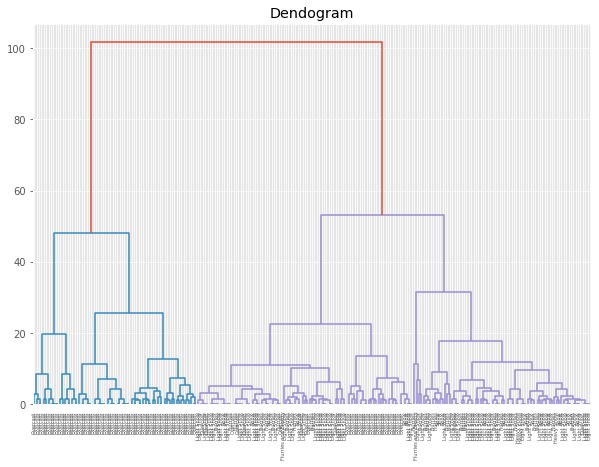

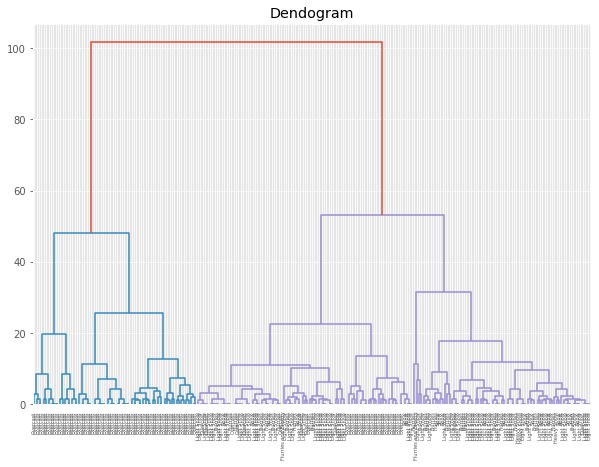

In [83]:
# create cluster for hiearachical clustering manual and sklearn and add label to each cluster
cluster_manual = []
cluster_sklearn = []
for i in range(3):
    cluster_manual.append([])
    cluster_sklearn.append([])
for i in range(len(myLabel)):
    cluster_manual[int(myLabel[i])].append(y[i])
    cluster_sklearn[int(skLabel[i])].append(y[i])

# print cluster
print("Cluster Manual")
for i in range(3):
    print(f"Cluster {i+1}: {cluster_manual[i]}")
print("Cluster Sklearn")
for i in range(3):
    print(f"Cluster {i+1}: {cluster_sklearn[i]}")
    
# Plot cluster for manual and sklearn hierachy with df_selected summary contains 'Snow', 'Flurries' and 'Overcast' as label
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X[:,0], X[:,1], c=myLabel, cmap='rainbow')
plt.scatter(X[:,0], X[:,1], c=myLabel, cmap='rainbow')
plt.title("Manual Hierarchical Clustering")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X[:,0], X[:,1], c=skLabel, cmap='rainbow')
plt.scatter(X[:,0], X[:,1], c=skLabel, cmap='rainbow')
plt.title("Sklearn Hierarchical Clustering")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

# Plot Dendogram for manual hierachy with df_selected summary contains 'Snow', 'Flurries' and 'Overcast' as label
plt.figure(figsize=(10, 7))
plt.title("Dendogram")
dend = hierarchy.dendrogram(hierarchy.linkage(X, method='complete'), labels = y)
plt.show()

# Plot Dendogram sklearn hierachy with df_selected summary contains 'Snow', 'Flurries' and 'Overcast' as label
plt.figure(figsize=(10, 7))
plt.title("Dendogram")
dend = hierarchy.dendrogram(hierarchy.linkage(X, method='complete'), labels = y)
plt.show()